In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.container {
    width: 100%;
}
</style>
""")

In [4]:
import graphlab as gl
gl.canvas.set_target('ipynb')
import tools 
import initialise

2016-03-16 21:31:48,564 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.4 started. Logging: /tmp/graphlab_server_1458163906.log


This non-commercial license of GraphLab Create is assigned to kevin.mcisaac@gmail.com and will expire on November 06, 2016. For commercial licensing options, visit https://dato.com/buy/.


## Automatic optimisation

In [5]:
train_data, test_data = initialise.load_data(reload_data=False)
folds = gl.cross_validation.KFold(train_data, 5)

Loading saved processed data
306  features in total


In [6]:
def auc_eval(model, train, test): 
    return {'train_auc':    model.evaluate(train, metric='auc')['auc'],
            'validate_auc': model.evaluate(test,  metric='auc')['auc']}

In [7]:
params = {'target':'TARGET', 'random_seed':8923,
          'class_weights':'auto','metric':'auc', 
          'max_iterations':3,
          'step_size': [0.03, 0.07, 0.1],
          'max_depth': [3, 4, 7, 9],
          'column_subsample': [1, 0.8, 0.6]}

job = gl.random_search.create(folds,gl.boosted_trees_classifier.create,
                             params, evaluator=auc_eval, max_models=20)

2016-03-16 21:31:51,943 [INFO] graphlab.deploy.job, 22: Validating job.
2016-03-16 21:31:51,958 [INFO] graphlab.deploy.job, 36: Creating a LocalAsync environment called 'async'.
2016-03-16 21:31:51,964 [INFO] graphlab.deploy.map_job, 186: Validation complete. Job: 'Model-Parameter-Search-Mar-16-2016-21-31-5100000' ready for execution
2016-03-16 21:31:52,091 [INFO] graphlab.deploy.map_job, 192: Job: 'Model-Parameter-Search-Mar-16-2016-21-31-5100000' scheduled.
2016-03-16 21:32:02,256 [INFO] graphlab.deploy.job, 22: Validating job.
2016-03-16 21:32:02,259 [INFO] graphlab.deploy.map_job, 220: A job with name 'Model-Parameter-Search-Mar-16-2016-21-31-5100000' already exists. Renaming the job to 'Model-Parameter-Search-Mar-16-2016-21-31-5100000-181c8'.
2016-03-16 21:32:02,265 [INFO] graphlab.deploy.map_job, 186: Validation complete. Job: 'Model-Parameter-Search-Mar-16-2016-21-31-5100000-181c8' ready for execution
2016-03-16 21:32:02,397 [INFO] graphlab.deploy.map_job, 192: Job: 'Model-Param

In [ ]:
job.get_status()


In [36]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep

total = job.get_status()['Completed'] + job.get_status()['Running'] + job.get_status()['Pending']

f = FloatProgress(min=0, max=total)
display(f)
while running > 0:
    f.value = total-job.get_status()['Running'] + job.get_status()['Pending']
    time.sleep(60)

results = job.get_results()

KeyboardInterrupt: 

In [ ]:
job.get_status()


In [ ]:
results.get_best_params(metric='validate_auc', ascending=False)

## Manual approach
Looks like depth:4, row: 1.00, col: 0.60, step: 0.10, gives the highest auc: 0.8465 

In [5]:
params = {'target':'TARGET', 'validation_set':validate,'verbose':False, 'random_seed':8923,
          'class_weights':'auto','metric':'auc',
          'early_stopping_rounds':10, 'max_iterations':300}
model=dict() 

for d in [2, 4, 6]:
    for r in [1, 0.8, 0.6]:
        for c in [1, 0.8, 0.6]:
            model[d,r,c] = gl.boosted_trees_classifier.create(train, 
                            max_depth=d, row_subsample=r, column_subsample=c, **params)
            print "depth: {:2d}, row: {:4.2f}, col: {:4.2f}, auc: {:6.4f}".format( d, r, c, model[d,r,c]['validation_auc'])


depth:  2, row: 1.00, col: 1.00, auc: 0.8424
depth:  2, row: 1.00, col: 0.80, auc: 0.8402
depth:  2, row: 1.00, col: 0.60, auc: 0.8426
depth:  2, row: 0.80, col: 1.00, auc: 0.8421
depth:  2, row: 0.80, col: 0.80, auc: 0.8417
depth:  2, row: 0.80, col: 0.60, auc: 0.8415
depth:  2, row: 0.60, col: 1.00, auc: 0.8420
depth:  2, row: 0.60, col: 0.80, auc: 0.8415
depth:  2, row: 0.60, col: 0.60, auc: 0.8397
depth:  4, row: 1.00, col: 1.00, auc: 0.8415
depth:  4, row: 1.00, col: 0.80, auc: 0.8437
depth:  4, row: 1.00, col: 0.60, auc: 0.8446
depth:  4, row: 0.80, col: 1.00, auc: 0.8414
depth:  4, row: 0.80, col: 0.80, auc: 0.8401
depth:  4, row: 0.80, col: 0.60, auc: 0.8407
depth:  4, row: 0.60, col: 1.00, auc: 0.8418
depth:  4, row: 0.60, col: 0.80, auc: 0.8435
depth:  4, row: 0.60, col: 0.60, auc: 0.8425
depth:  6, row: 1.00, col: 1.00, auc: 0.8384
depth:  6, row: 1.00, col: 0.80, auc: 0.8445
depth:  6, row: 1.00, col: 0.60, auc: 0.8399
depth:  6, row: 0.80, col: 1.00, auc: 0.8389
depth:  6,

In [8]:
d=4
r=1
c=0.6
for s in [0.3, 0.1, 0.05, 0.01]:
    model[d,r,c, s] = gl.boosted_trees_classifier.create(train, 
                    max_depth=d, row_subsample=r, column_subsample=c, step_size=s, **params)
    print "depth: {:2d}, row: {:4.2f}, col: {:4.2f}, step: {:4.2f}, auc: {:6.4f}".format( d, r, c, s,model[d,r,c, s]['validation_auc'])


depth:  4, row: 1.00, col: 0.60, step: 0.30, auc: 0.8446
depth:  4, row: 1.00, col: 0.60, step: 0.10, auc: 0.8459
depth:  4, row: 1.00, col: 0.60, step: 0.05, auc: 0.8345
depth:  4, row: 1.00, col: 0.60, step: 0.01, auc: 0.8274


In [9]:
d=4
r=1
c=0.6
for s in [.5, .8, 1]:
    model[d,r,c, s] = gl.boosted_trees_classifier.create(train, 
                    max_depth=d, row_subsample=r, column_subsample=c, step_size=s, **params)
    print "depth: {:2d}, row: {:4.2f}, col: {:4.2f}, step: {:4.2f}, auc: {:6.4f}".format( d, r, c, s,model[d,r,c, s]['validation_auc'])


depth:  4, row: 1.00, col: 0.60, step: 0.50, auc: 0.8426
depth:  4, row: 1.00, col: 0.60, step: 0.80, auc: 0.8335
depth:  4, row: 1.00, col: 0.60, step: 1.00, auc: 0.8367


In [9]:
params = {'target':'TARGET', 'validation_set':validate,'verbose':True, 'random_seed':8923,
          'class_weights':'auto','metric':'auc',
          'early_stopping_rounds':20, 'max_iterations':300}
d=4; r=1; c=0.6; s=0.1;
model = gl.boosted_trees_classifier.create(train, 
                    max_depth=d, row_subsample=r, column_subsample=c, 
                                           step_size=s, **params)

WARNING: Detected extremely low variance for feature(s) 'var33 delta transfer amount out 1Y3', 'var33 transfer amount out ultima1', 'var33 number transfer out ultima1' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 60568

Number of classes           : 2

Number of feature columns   : 306

Number of unpacked features : 306

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.220089     | 0.820057     | 0.820064       |

| 2         | 0.353484     | 0.827293     | 0.827227       |

| 3         | 0.485838     | 0.829357     | 0.827584       |

| 4         | 0.612038     | 0.834063     | 0.830770       |

| 5         | 0.736314     | 0.836802     | 0.832260       |

| 6         | 0.866265     | 0.836398     | 0.830956       |

| 10        | 1.385734     | 0.842514     | 0.836543       |

| 11        | 1.519280     | 0.843680     | 0.837302       |

| 20        | 2.714417     | 0.850309     | 0.840667       |

| 30        | 4.048095     | 0.855640     | 0.843102       |

| 40        | 5.365654     | 0.859954     | 0.844236       |

| 50        | 6.718256     | 0.863559     | 0.844840       |

| 51        | 6.847785     | 0.864025     | 0.844999       |

| 60        | 8.039890     | 0.866464     | 0.845110       |

| 70        | 9.339863     | 0.868462     | 0.845052       |

| 80        | 10.653769    | 0.870623     | 0.844900       |

| 90        | 11.968243    | 0.872021     | 0.845067       |

+-----------+--------------+--------------+----------------+

Early stop triggered. Returning the best model at iteration: 71

In [21]:
model.evaluate(validate, metric='confusion_matrix')

{'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  142  |
 |      1       |        1        |  483  |
 |      0       |        1        |  3286 |
 |      0       |        0        | 11541 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns]}

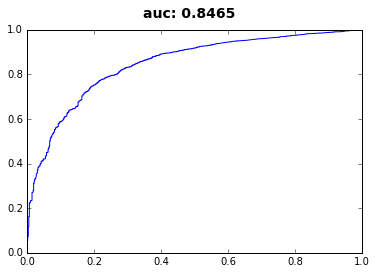

In [28]:
reload(tools)
tools.plot_roc(model, validate);

In [41]:
reload(tools)
tools.make_submission(model, test_data, "GBT 1")
# 475 auc: 0.837421